In [ ]:
!pip uninstall keras 
!pip install keras==2.2.4

In [ ]:
!pip install h5py==2.10.0 --force-reinstall #need to install h5 ,otherwise it won't load the model properly

Reference: https://github.com/gsurma/style_transfer

In [ ]:
!pip uninstall tensorflow 
!pip install tensorflow-gpu==1.14

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 377.1 MB 6.5 kB/s 
     |████████████████████████████████| 488 kB 74.7 MB/s 
     |████████████████████████████████| 3.1 MB 54.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [ ]:
# Hyperparams
ITERATIONS = 5
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Paths
input_image_path = "/content/gdrive/MyDrive/Flood Project/input.png"
style_image_path = "/content/gdrive/MyDrive/Flood Project/style.png"
output_image_path = "/content/gdrive/MyDrive/Flood Project/output.png"
combined_image_path = "/content/gdrive/MyDrive/Flood Project/combined.png"

# REAL image
san_francisco_image_path = "/content/gdrive/MyDrive/Flood Project/image_110.png"

# Synthetic Image
tytus_image_path = "/content/gdrive/MyDrive/Flood Project/0633005.png"

In [ ]:
from PIL import Image

#im1 = Image.open(r'/content/gdrive/MyDrive/Flood Project/image_110.jpg')           #convert image from jpg to png
#im1.save(r'/content/gdrive/MyDrive/Flood Project/image_110.png')

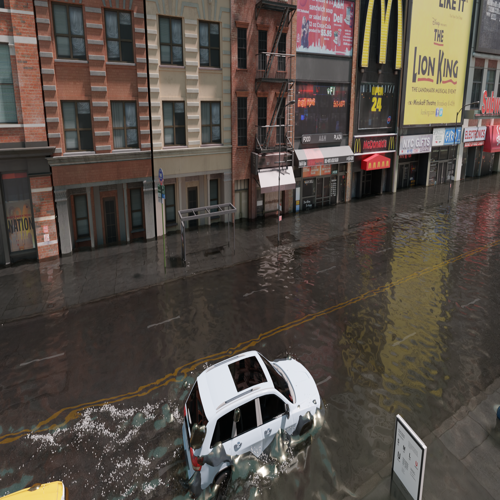

In [ ]:
#Input visualization 
input_image = Image.open(tytus_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

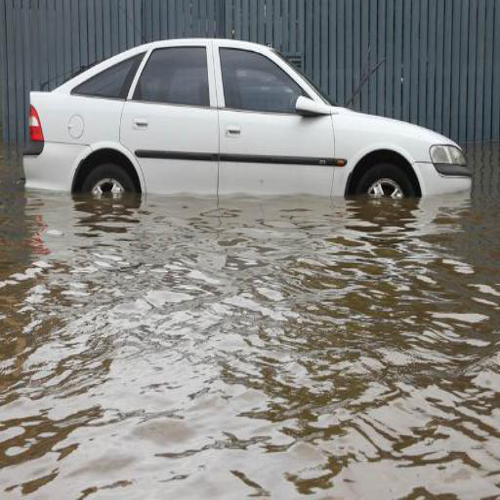

In [ ]:
# Style visualization 
style_image = Image.open(san_francisco_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [ ]:
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = input_image_array[:, :, :3]
input_image_array.shape

(500, 500, 3)

In [ ]:
style_image_array = np.asarray(style_image, dtype="float32")
style_image_array.shape

(500, 500, 3)

In [ ]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = input_image_array[:, :, :3]
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [ ]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)





58892288/58889256 [==============================] - 3s 0us/step




In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss =loss+ CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

In [ ]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [ ]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [ ]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 0 completed with loss 29903388672
Iteration 1 completed with loss 13104945152
Iteration 2 completed with loss 9304457216
Iteration 3 completed with loss 8514419712
Iteration 4 completed with loss 8275840000


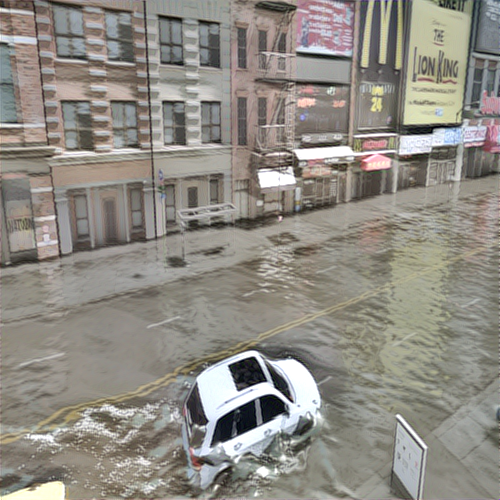

In [ ]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

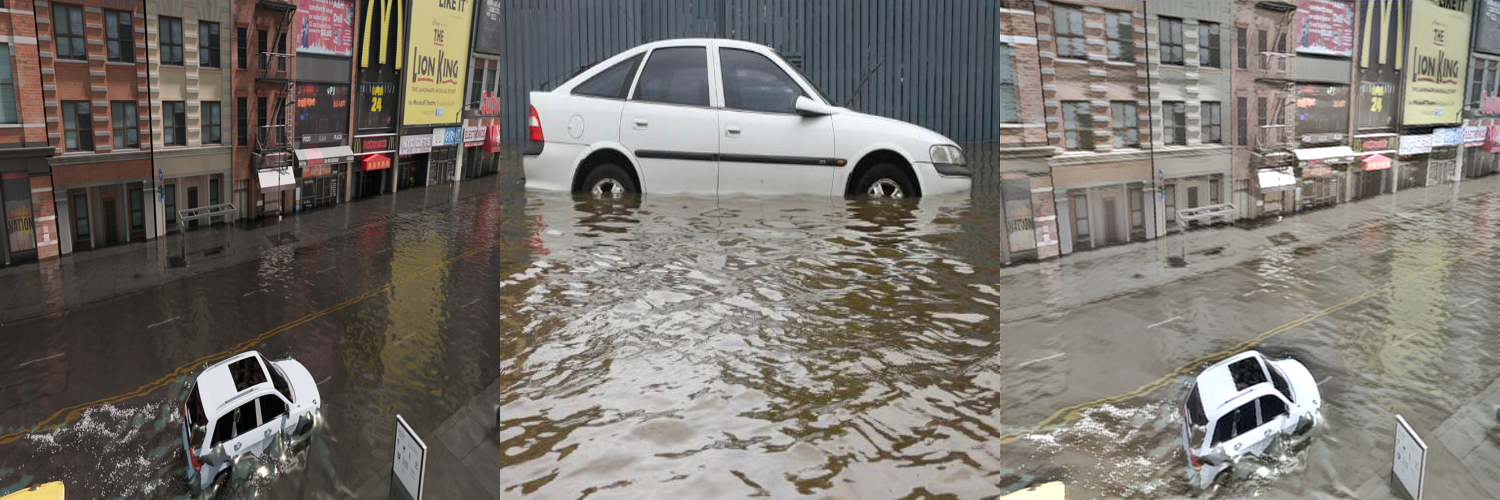

In [ ]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined

##FID distance calculation between style (real) and translated (output) image

Reference: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [ ]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))



87916544/87910968 [==============================] - 10s 0us/step


In [ ]:
style_image=Image.open(style_image_path)
#style_image=style_image.resize((229, 229))
output_image=Image.open(output_image_path)
#output_image=output_image.resize((229, 229))

In [ ]:
# convert integer to floating point values
images1 = np.asarray(style_image, dtype="float32")
images2 = np.asarray(output_image, dtype="float32")

In [ ]:
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

Scaled (500, 299, 299, 3) (500, 299, 299, 3)


In [ ]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

In [ ]:
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

FID (different): 65.657


The authors of the score show that lower FID scores correlate with better-quality images when systematic distortions were applied such as the addition of random noise and blur.

FID distance between style (real) image and translated (output) image after 5 iteration is 65.657

FID distance between style (real) image and translated (output) image after 10 iteration is 68.941

FID distance between style (real) image and translated (output) image after 50 iteration is 75.424